In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [10]:
env = gym.make("CartPole-v1")
observation, info = env.reset()
returns = []

G = 0
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    G += reward

    if terminated or truncated:
        observation, info = env.reset()
        returns.append(G)
        G = 0

env.close()

Text(0, 0.5, 'Return')

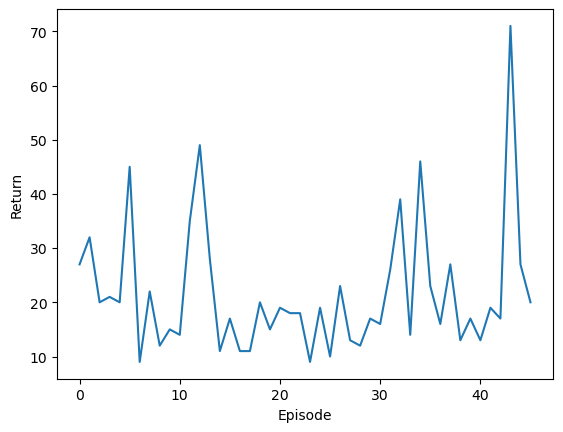

In [12]:
plt.plot(np.arange(len(returns)), returns)
plt.xlabel("Episode")
plt.ylabel("Return")